In [1]:
from Pre_Processing import *
import numpy as np
import pandas as pd
import math

from sklearn.preprocessing import MinMaxScaler
from keras.layers import *
from keras.models import *

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

2022-05-01 21:34:13.687431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 21:34:13.687481: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Error loading stopwords: <urlopen error [Errno 104]
[nltk_data]     Connection reset by peer>


In [233]:
month = "december"
year=2017
LSTM_data = prepare_data_LSTM(month=month,year=year)


In [217]:
LSTM_data.head()

,4_bitcoin_price_coin_money,6_market_report_share_company,9_steemit_upvote_comment_vote,13_post_follow_content_read,close
timestamp,,,,,
2018-01-01,0.606258,0.683181,0.841572,0.880299,4.01
2018-01-02,0.536905,0.668969,0.847874,0.878371,6.69
2018-01-03,0.610203,0.665668,0.814142,0.868791,8.03
2018-01-04,0.598255,0.679881,0.810370,0.885999,6.56
2018-01-05,0.585906,0.699818,0.864995,0.891050,5.81


In [137]:
import datetime

MIN_DATE = datetime.date(2017,10,1)
MAX_DATE = datetime.date(2018,6,30)

price_data = pd.read_csv("SteemCoinFull.csv",sep=";")
price_data["Date"] = pd.to_datetime(price_data["Date"])
price_data["Date"] = pd.to_datetime(price_data["Date"]).dt.date
price_data.columns = ["timestamp","open","high","low","close","volume","market_cap"]

price_data = price_data[(price_data["timestamp"]>=MIN_DATE) & (price_data["timestamp"]<=MAX_DATE)]
price_data = price_data.sort_values(by="timestamp")
price_data = price_data.reset_index()
price_data = price_data.drop("index",axis=1)
price_data = price_data.drop(["open","high","low","volume","market_cap"],axis=1)


LSTM_data = price_data.copy()
LSTM_data["close"] = LSTM_data["close"].str.replace(',', '.').astype(float)
LSTM_data = LSTM_data.set_index("timestamp")
LSTM_data

,close
timestamp,
2017-10-01,1.41
2017-10-02,1.31
2017-10-03,1.23
2017-10-04,1.18
2017-10-05,1.17
...,...
2018-06-26,1.27
2018-06-27,1.27
2018-06-28,1.18


In [234]:
dataset = LSTM_data.close.values
dataset = dataset.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = 1
print('Number of features', num_of_features)

Number of features 1


In [235]:
look_back = 1
lstm_layers = 64
epochs=125


In [236]:
def create_dataset(dataset, look_back=5):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

train_size_percent = 0.80


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]


trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [237]:
trainX.shape

(22, 1)

In [238]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

In [239]:
print(trainX.shape,testX.shape)

(22, 1, 1) (5, 1, 1)


In [240]:
model = Sequential()
model.add(Bidirectional(LSTM(lstm_layers, input_shape=(look_back,num_of_features))))
model.add(Dense(5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.30, epochs=epochs,shuffle=False)

Epoch 1/125
1/1 [==============================] - 31s 31s/step - loss: 0.0694 - val_loss: 0.5705
Epoch 2/125
1/1 [==============================] - 0s 195ms/step - loss: 0.0642 - val_loss: 0.5452
Epoch 3/125
1/1 [==============================] - 0s 244ms/step - loss: 0.0592 - val_loss: 0.5205
Epoch 4/125
1/1 [==============================] - 0s 231ms/step - loss: 0.0545 - val_loss: 0.4963
Epoch 5/125
1/1 [==============================] - 0s 197ms/step - loss: 0.0500 - val_loss: 0.4728
Epoch 6/125
1/1 [==============================] - 0s 127ms/step - loss: 0.0458 - val_loss: 0.4498
Epoch 7/125
1/1 [==============================] - 0s 177ms/step - loss: 0.0417 - val_loss: 0.4275
Epoch 8/125
1/1 [==============================] - 0s 243ms/step - loss: 0.0380 - val_loss: 0.4058
Epoch 9/125
1/1 [==============================] - 0s 123ms/step - loss: 0.0344 - val_loss: 0.3847
Epoch 10/125
1/1 [==============================] - 0s 151ms/step - loss: 0.0311 - val_loss: 0.3643
Epoch 11/1

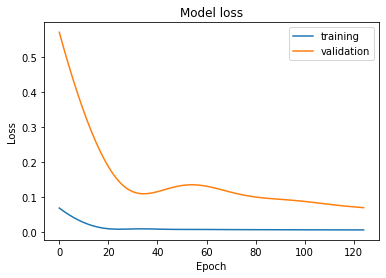

In [241]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [242]:
trainPredict = model.predict(trainX) # Trainset predictions
testPredict = model.predict(testX) # Test_set predictions

#scale back
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

trainY_back = scaler.inverse_transform(trainY.reshape(-1,1))
testY_back = scaler.inverse_transform(testY.reshape(-1,1))


# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY_back, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY_back, testPredict))


# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY_back - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY_back - testPredict))/len(testY)


In [243]:
print(trainScore_RMSE, trainScore_MAE)

0.42362595946739007 0.30237215497277


In [244]:
print(testScore_RMSE, testScore_MAE)

0.5269703880051597 0.4699025077819825


Text(0.5, 1.0, 'Steem Price Prediction')

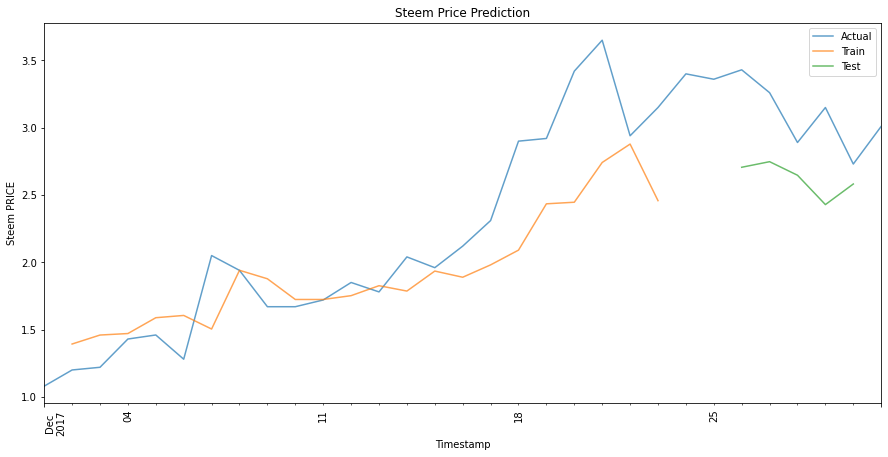

In [245]:
# shift train predictions for plotting

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict


# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict


# contruct pandas dataframe for plotting
time_df = pd.DataFrame(LSTM_data.index)
time_df['Actual'] = scaler.inverse_transform(dataset)
df1 = pd.DataFrame(trainPredictPlot,columns=['Train'])
df2 = pd.DataFrame(testPredictPlot,columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=False)
time_df2.set_index('timestamp',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Steem PRICE')
plt.title('Steem Price Prediction')


In [247]:
print(testScore_RMSE, testScore_MAE)

0.5269703880051597 0.4699025077819825


In [249]:
data = {'LSTM_close':  ['0.5269703880051597', '0.4699025077819825',"0.42362595946739007","0.30237215497277"],
        'LSTM_multivariate': ['0.3181908681057473 ', '0.30552508471455464',"0.31936864363159273","0.24044375061630435"]}

pd.DataFrame(data, index=['testScore_RMSE','testScore_MAE','trainScore_RMSE','trainScore_MAE'])

,LSTM_close,LSTM_multivariate
testScore_RMSE,0.5269703880051597,0.3181908681057473
testScore_MAE,0.4699025077819825,0.30552508471455464
trainScore_RMSE,0.42362595946739007,0.31936864363159273
trainScore_MAE,0.30237215497277,0.24044375061630435
